In [ ]:
from fastai.basics import *
from fastai.vision.all import *
from sklearn import metrics

/home/tiago/anaconda3/envs/fastai/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370151529/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from my_utils import dotdict

In [ ]:
from wandb_sweep import get_dls, get_learner

In [ ]:
from model_eval import get_preds, plot_CM, plot_CM_PR, plot_top_losses_glitches, plot_CM_chirp_line

In [ ]:
import wandb

api = wandb.Api()

In [ ]:
sweep_id = "m4nqsh6e"
sweep = api.sweep(f"ogait/thesis_gravity_spy/{sweep_id}")
best_run_config = sweep.best_run().config

wandb: Sorting runs by -summary_metrics.combined_f1_time


In [ ]:
config = dotdict(best_run_config)
config.correct_labels = True
config.inference = True
config.real_gw_eval = True

In [ ]:
config.real_gw_version = '8'

In [ ]:
dls, _, n_channels = get_dls(config)
learner = get_learner(config, dls, n_channels)
vocab = list(learner.dls.train_ds.class_dict.keys())
learner.load(f"{sweep_id}_run{config.experiment_no}")

<fastai.learner.Learner>

In [ ]:
preds, targets, soft_preds, y_true1, y_pred1 = get_preds(learner, ds_idx=2)

In [ ]:
cm1 = metrics.confusion_matrix(y_true1, y_pred1, labels=np.arange(22))
acc = metrics.accuracy_score(y_true1, y_pred1) * 100
f1 = metrics.f1_score(y_true1, y_pred1, average="macro") * 100
print(f"Overall accuracy: {acc:.2f}%")
print(f"Macro-averaged F1-score: {f1:.2f}%")

Overall accuracy: 10.00%
Macro-averaged F1-score: 6.06%


In [ ]:
sweep_id = "1cesj6eh"
sweep = api.sweep(f"ogait/thesis_gravity_spy/{sweep_id}")
best_run_config = sweep.best_run().config

wandb: Sorting runs by -summary_metrics.combined_f1_time


In [ ]:
config = dotdict(best_run_config)
config.correct_labels = True
config.inference = True
config.real_gw_eval = True

In [ ]:
config.real_gw_version = '8'

In [ ]:
dls, _, n_channels = get_dls(config)
learner = get_learner(config, dls, n_channels)
vocab = list(learner.dls.train_ds.class_dict.keys())
learner.load(f"{sweep_id}_run{config.experiment_no}")

<fastai.learner.Learner>

In [ ]:
preds, targets, soft_preds, y_true2, y_pred2 = get_preds(learner, ds_idx=2)

In [ ]:
cm2 = metrics.confusion_matrix(y_true2, y_pred2, labels=np.arange(22))
acc = metrics.accuracy_score(y_true2, y_pred2) * 100
f1 = metrics.f1_score(y_true2, y_pred2, average="macro") * 100
print(f"Overall accuracy: {acc:.2f}%")
print(f"Macro-averaged F1-score: {f1:.2f}%")

Overall accuracy: 52.00%
Macro-averaged F1-score: 11.40%


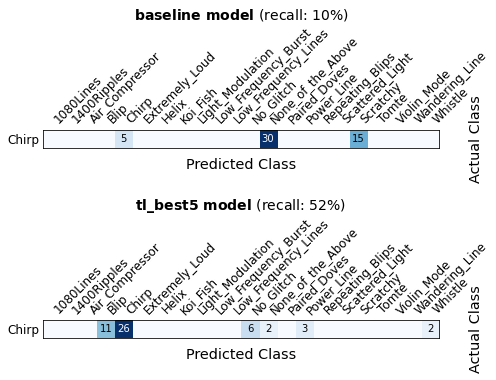

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(7, 6))
axs[0] = plot_CM_chirp_line(axs[0], cm1, vocab=vocab, normalize=False, y_true=y_true1, y_pred=y_pred1)
axs[0].set_title("$\mathbf{baseline\ model}$ (recall: 10%)", fontsize=14);
axs[1] = plot_CM_chirp_line(axs[1], cm2, vocab=vocab, normalize=False, y_true=y_true2, y_pred=y_pred2)
axs[1].set_title("$\mathbf{tl\_best5\ model}$ (recall: 52%)", fontsize=14)
plt.tight_layout()
fig.savefig('../figs/glitches/18_o3gws_lmatrixes.pdf', dpi=600, bbox_inches="tight")

In [ ]:
interp = Interpretation.from_learner(learner, ds_idx=2)

In [ ]:
def plot_some_gws(interp, learner, ds_idx=2, largest=True, figsize=(11, 11),
                  y_preds=None, vocab=None,
                  show_label=True, show_pred=True, show_loss=False,
                  nrows=None, ncols=None, select_idxs = None
):
    """Plot top losses for selected samples from the real GW events dataset."""
    assert len(select_idxs) == nrows*ncols
    
    ds = learner.dls.loaders[ds_idx].dataset
    top_losses = interp.top_losses(len(ds), largest=largest)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, sharey=True)
    cur_ax = 0
    for i, idx in enumerate(top_losses[1]):
        if i in select_idxs:
            ax = axes.flat[cur_ax]
            cur_ax += 1
            idx = int(idx)
            true_label = vocab[ds[idx][1]]
            freq_pos = np.linspace(-100, 2048, 9)[1:-1]
            freqs = np.logspace(3, 11, num=9, base=2)[1:-1]
            view_time = 4
            times = np.linspace(-view_time / 2, view_time / 2, 5)

            img = ax.imshow(
                ds[idx][0].permute(1, 2, 0),
                extent=[-view_time / 2, view_time / 2, 8, 2048],
                aspect=140 / 170 * view_time / 2038,
            )
            ax.tick_params(axis="both", which="both", length=0)
            ax.set_xticks([])
            ax.set_yticks([])
        
            title = [r"$\bf{" + ds.events[idx].replace("_", " - ") + "}$"]
            if show_label:
                title.append(f"label: {true_label}")
            if show_pred:
                title.append(f"pred: {vocab[y_preds[idx]]}")
            if show_loss:
                title.append(f"loss: {top_losses[0][i+first_idx]:.2e}")
            if title:
                ax.set_title("\n".join(title))

    # for ax in axes[:,0]: ax.set_ylabel('Frequency (Hz)')
    fig.tight_layout()

    return fig, axes


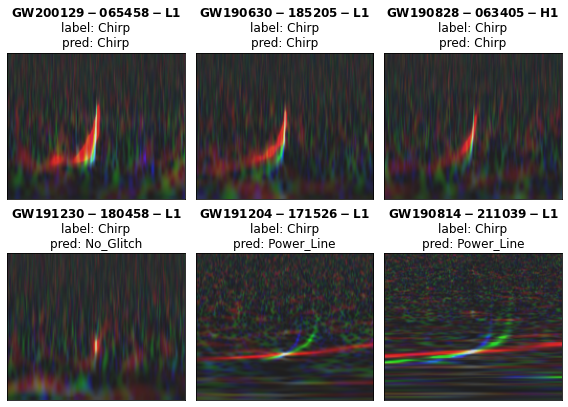

In [ ]:
fig, ax = plot_some_gws(interp, learner, vocab=vocab, ds_idx=2,
    y_preds=y_pred2,
    largest=False, nrows=2, ncols=3,
    show_label=True, show_pred=True, show_loss=False,
    figsize=(8, 6),
    select_idxs = [2, 3, 4, 43, 44, 45]
)

fig.savefig('../figs/glitches/18_o3gws_tlosses.pdf', dpi=600, bbox_inches="tight")